# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
1. use command-line script to get prediction dataset
2. shifting code to, working with full data on remote PC
3. CRPS averaging. sanity checks.  re-writing rank histogram.
4. creating function to compare different models on CRPS, Spread-skill, RankHistogram. should be simple.

call niput_number- time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will

In [3]:
tf.__version__

'1.14.0'

In [8]:
datadir = '/Users/sagar/Library/Mobile\ Documents/com~apple~CloudDocs/studies/WeatherBench/Testing_WeatherBench/5.625deg/'# Change this to where you downloaded the data

In [9]:
!ls $datadir

13-mean.nc                     geopotential
13-resnet_bn_dr_0.1.h5         temperature
13-resnet_bn_dr_0.1_weights.h5 u_component_of_wind
13-std.nc                      v_component_of_wind
constants


In [10]:
exp_id = '13-resnet_bn_dr_0.1'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 
            'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 
            'constants': ['lsm','orography','lat2d']}  

output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72 #prediction of forecast is at 72 hours after input time.
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = 1
dropout = 0.1  # This is the important one

batch_size = 32
nt_in = 1
l2 = 0
skip = True

In [11]:
#ds = xr.merge([xr.open_mfdataset('../test/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]) 
df1=xr.open_mfdataset('../5.625deg/geopotential/*.nc', combine='by_coords') 
df2=xr.open_mfdataset('../5.625deg/temperature/*.nc', combine='by_coords') 
df3=xr.open_mfdataset('../5.625deg/u_component_of_wind/*.nc', combine='by_coords') 
df4=xr.open_mfdataset('../5.625deg/v_component_of_wind/*.nc', combine='by_coords')  
df5=xr.open_mfdataset('../5.625deg/constants/*.nc', combine='by_coords')  
ds=xr.merge([df1,df2,df3,df4,df5])

In [12]:
mean = xr.open_dataarray('../5.625deg/13-mean.nc') #for just our subsampled data. 15 levels ('the constants are at level=1)':z200,z500,z850,t200 and so on.
std = xr.open_dataarray('../5.625deg/13-std.nc')

In [13]:
dg_test = DataGenerator(
    ds, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
    shuffle=False, output_vars=output_vars
)

DG start 19:00:48.846015
DG normalize 19:00:48.897251
DG load 19:00:48.915102
Loading data into RAM
DG done 19:01:18.738878


In [16]:
# You can index into the data generator to obain a feature/target pair
# [batch, x, y, channel]
X,y=dg_test[0]
X.shape, y.shape

((32, 32, 64, 15), (32, 32, 64, 2))

In [23]:
ds

<xarray.Dataset>
Dimensions:    (lat: 32, level: 11, lon: 64, time: 8760)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level      (level) int32 1 10 100 200 300 400 500 600 700 850 1000
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    z          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>
    t          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>
    u          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>
    v          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>
    orography  (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    lsm        (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    slt        (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    lat2d      (lat, lon) float64 dask.array<chunksize=(32, 64), meta=np.ndarray>
    lon2d      (lat, lon) float64 dask.array<chunksize=(32, 64), meta=np.ndarray>

In [ ]:
#ToDo: #Get full data in X,Y instead of just 1 batch
for (X,y) in dg_test
     X,y=dg_test(i)
      append

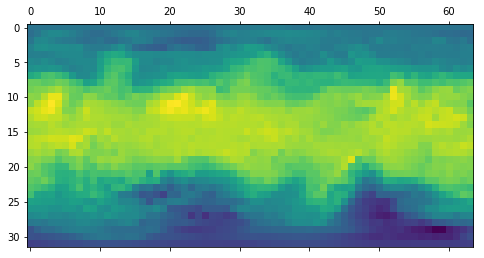

In [12]:
plt.matshow(y[0, :, :, 1]) #y[...,0] is z500 and y[...,1] is t850. normalized. 
#y is the observation after lead_time (=72) hours from input X. The ground truth.

# Load the model
Now let's load the pretrained model. Check the build resnet option .

In [13]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_test.data.lat), len(dg_test.data.lon), len(dg_test.data.level) * nt_in),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
dg_test.data.lat
X

array([[[[-0.7220457 , -0.86677206, -0.8451589 , ...,  1.444262  ,
           2.5708556 , -1.6787441 ],
         [-0.716825  , -0.85551417, -0.8148069 , ...,  1.444262  ,
           2.6368482 , -1.6787441 ],
         [-0.7129068 , -0.8442563 , -0.7793859 , ...,  1.444262  ,
           2.7012208 , -1.6787441 ],
         ...,
         [-0.73770785, -0.90505356, -0.9513914 , ...,  1.444262  ,
           2.4068856 , -1.6787441 ],
         [-0.73248714, -0.89379567, -0.92103946, ...,  1.444262  ,
           2.473789  , -1.6787441 ],
         [-0.72726643, -0.88028157, -0.8856288 , ...,  1.444262  ,
           2.522474  , -1.6787441 ]],

        [[-0.7794736 , -1.0311421 , -1.0424467 , ...,  1.444262  ,
           2.0627558 , -1.570438  ],
         [-0.7664218 , -0.9793557 , -0.9311561 , ...,  1.444262  ,
           2.334417  , -1.570438  ],
         [-0.7546752 , -0.92531776, -0.8198655 , ...,  1.444262  ,
           2.4794586 , -1.570438  ],
         ...,
         [-0.8094954 , -1.1257131 

In [14]:
model.compile('adam', 'mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  94208       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         activation[0][0]                 
______________________________________________________________________________________________

In [15]:
model.load_weights('../test/13-resnet_bn_dr_0.1_weights.h5')

## Create a deterministic prediction

The model has been trained to create a deterministic prediction. For this dropout is turned off during test time. Let's create a prediction for the first sample. Thanks to Tensorflow 2 we can tread the model as a function just like in PyTorch.

In [15]:
#pred = model(X[:1]).numpy().squeeze(); pred.shape; #to add tf.enable_eager_execution() in src/networks.py line6. have to remove if you want to run ensemble prediction :(.

In [16]:
# Look at the predictions
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.matshow(pred[..., 0]) #z500 normalized
# ax2.matshow(pred[..., 1]) #t850 normalized

# Create an ensemble using test-time dropout
Now it's your turn. The pretrained model contains several dropout layers which are only active during training. Your job is to turn dropout on during inference as well. This should result in a model that creates a slightly different prediction every time. Hint: Google "Keras test-time dropout".

In [16]:
##weirdly this function works when tf.enable_eager_execution() is disabled.
#but 'pred' for single determinstic works when tf.enable_eager_execution() is enabled. 
#issue with tensorflow version. couldn't solve right now.

#keras switches off test time dropout by default. we could either switch it on permanently.. by putting somewhere an argument training=true). this will put both training and testing to use dropout
#but since we have a pre trained model, better just to activate dropout in testing rather than training again. beware: we also activate bacthnorm or any other that was inactive in test phase by default.
#https://stackoverflow.com/questions/52756283/adding-dropout-to-testing-inference-phase
from tensorflow.keras import backend as K
func = K.function(model.inputs + [K.learning_phase()], model.outputs)

In [17]:
# to use dropout in testing phase, pass 1 to set the learning phase to training mode
outputs = func([X[:1]] + [1.]) #for a single sample. #gives a new prediction each time.
pred2 = np.asarray(outputs, dtype=np.float32).squeeze(); print(pred2.shape) #reshape
#outputs

(32, 64, 2)


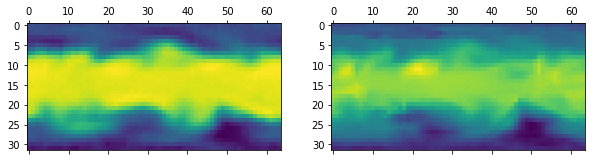

In [18]:
# Look at the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred2[..., 0]) #z500 normalized
ax2.matshow(pred2[..., 1]) #t850 normalized

# Creating Ensemble Forecasts
 I Inputs. N forecasts per input.

In [21]:
number_of_forecasts=100
time=10 ## keep it lower for testing code. takes time.
#number of inputs. different input times each for which an ensemble of predictions is made. 

#explanatory version
# pred_ensemble=np.ndarray(shape=(time,number_of_forecasts,32,64,2),dtype=np.float32)
# for i in range(time):
#     for f in range(number_of_forecasts):
#         outputs = func([X[i:i+1]] + [1.]) #new prediction each time for same sample.
#         pred1 = np.asarray(outputs, dtype=np.float32).squeeze()
#         pred_ensemble[i,f,...] = pred1 

#concise version
pred_ensemble = np.array([np.asarray(func([X[:time]] + [1.]), dtype=np.float32).squeeze() for _ in range(number_of_forecasts)])


In [22]:
print(pred_ensemble.shape) #(forecast, time, lat, lon, variable)

(100, 10, 32, 64, 2)


In [23]:
y[:time].shape #ground truth. Is this correct?

(10, 32, 64, 2)

In [24]:
#convert to xarray dataset
preds = xr.Dataset({
    'z500': xr.DataArray(pred_ensemble[...,0],
        dims=['forecast_number', 'time','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'time': np.arange(time), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
    ,
    't850': xr.DataArray(pred_ensemble[...,1],
        dims=['forecast_number', 'time','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'time': np.arange(time), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
})

observation= xr.Dataset({
    'z500': xr.DataArray(y[:time,:,:,0],
                         dims=['time','lat','lon'],
                         coords={'time':np.arange(time),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
    ,
    't850': xr.DataArray(y[:time,:,:,1],dims=['time','lat','lon'],coords={'time':np.arange(time),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)          
})

In [25]:
#preds

<xarray.Dataset>
Dimensions:          (forecast_number: 100, lat: 32, lon: 64, time: 10)
Coordinates:
  * forecast_number  (forecast_number) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * time             (time) int64 0 1 2 3 4 5 6 7 8 9
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500             (forecast_number, time, lat, lon) float32 -1.0821395 ... -1.6251754
    t850             (forecast_number, time, lat, lon) float32 -1.2627084 ... -1.7247591

In [26]:
#observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z500     (time, lat, lon) float32 -1.1572351 -1.136971 ... -1.2945862
    t850     (time, lat, lon) float32 -0.90364563 -0.89726615 ... -1.5544755

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.
#ToDo: 
unnormalize data for all scores.
check if properscoring exists for xarray
build sanity checks (Eg: MAE=CRPS for 1 ensemble member)
see why rank histogram behaviour is weird:
    spread-skill ratio is high: so forecast has high spread, low peak
    rank histogram shows opposite: overconfident (underdispersive): low spread, high peak.

In [68]:
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)

ensemblemean=preds.mean('forecast_number')
mean_rmse=compute_weighted_rmse(observation,ensemblemean); print(mean_rmse)

#spread_skill_ratio=mean_spread/mean_rmse; print(spread_skill_ratio)
spread_skill_ratio_z500=mean_spread.z500_mean_spread/mean_rmse.z500_rmse
spread_skill_ratio_t850=mean_spread.t850_mean_spread/mean_rmse.t850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) #CouldDo: make a single Dataset by keeping same name as z500, t850

<xarray.Dataset>
Dimensions:           ()
Data variables:
    z500_mean_spread  float64 0.1983
    t850_mean_spread  float64 0.2001
<xarray.Dataset>
Dimensions:    ()
Data variables:
    z500_rmse  float64 0.1255
    t850_rmse  float64 0.141
<xarray.DataArray ()>
array(1.57983298)
<xarray.DataArray ()>
array(1.41961822)


In [82]:
#Method 2: Continuous Ranked Probablity Score (properscoring package)
crps_score=crps_score(observation, preds,1); print(crps_score)
#ToDo: solve this error. if i re-run cell block 2 (from src.score import *), then it runs fine. See next cell block. possibly becasue  change datatype by calling to_array() function)

TypeError: 'Dataset' object is not callable

In [84]:
#Method 2: Continuous Ranked Probablity Score
#!pip install properscoring
crps_score=crps_score(observation, preds,1); print(crps_score)
#ToDo: 1 refers to forecast_number dimension. need to generalize that.
#check if propoerscoring function exists for xarray

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 0.06523
    t850     float64 0.08424


In [31]:

#sanity check
#create function for MAE. MAE=crps for 1 ensemble member

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 0.08901
    t850     float64 0.09419
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 0.06513
    t850     float64 0.08452


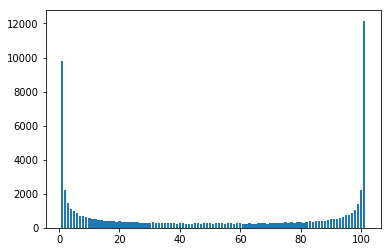

In [32]:
#Method 3: Rank Histogram
# !pip install rank-histogram
# does prediction need to be a sorted array? How does that work for a data that has lat,lon?
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() #Definitely bad. maybe because too few observations or beacuse of bad implementation

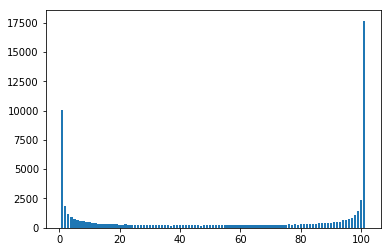

In [33]:
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show() 

In [34]:
print(obs_t850.shape)
pred_t850.shape

(32, 32, 64)


(100, 32, 32, 64)

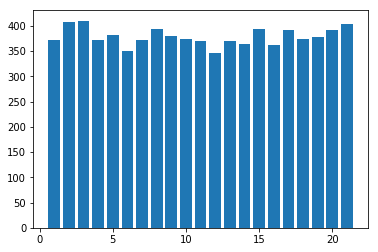

In [35]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

(32, 3)
(100, 32, 3)
(32, 3)


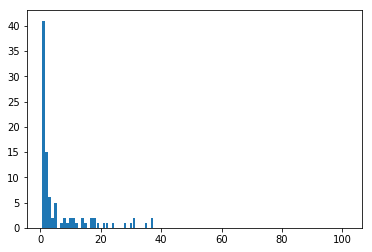

In [36]:
#testing for only few points
obs_small=obs_z500[:,15:18,0].squeeze()
pred_small=pred_z500[:,:,15:18,0]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show()

(32, 32, 64)
(10, 32, 32, 64)
(32, 32, 64)


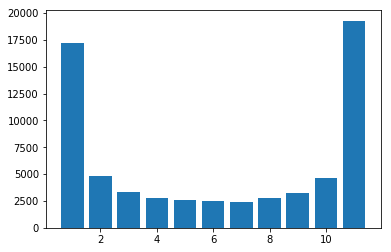

In [37]:
#testing for smaller number of bins (i.e. forecasts)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #still bad. same shape. overconfident (underdispersive)

In [ ]:
#self implementation
import pandas as pd #will make for xarray later.
combined=np.vstack((obs[np.newaxis],ensemble))
# print('computing ranks')
ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

# print('computing ties')
ties=np.sum(ranks[0]==ranks[1:], axis=0)
ranks=ranks[0]
tie=np.unique(ties)

    for i in range(1,len(tie)):
        index=ranks[ties==tie[i]]
        # print('randomizing tied ranks for ' + str(len(index)) + ' instances where there is ' + str(tie[i]) + ' tie/s. ' + str(len(tie)-i-1) + ' more to go')
        ranks[ties==tie[i]]=[np.random.randint(index[j],index[j]+tie[i]+1,tie[i])[0] for j in range(len(index))]

    return np.histogram(ranks, bins=np.linspace(0.5, combined.shape[0]+0.5, combined.shape[0]+1))

In [38]:
import pandas as pd
obs_small=observation.to_dataframe()
pred_small=preds.to_dataframe()

In [41]:
pred_small.shape

(6553600, 2)

In [44]:
my_vec = pd.Series([1,2,4,2,3,1])
my_vec.sample(frac=1).rank(method='first').reindex_like(my_vec)

0    2.0
1    4.0
2    6.0
3    3.0
4    5.0
5    1.0
dtype: float64

In [46]:
my_vec.sample(frac=1).rank(method='first').reindex_like(my_vec)

0    2.0
1    3.0
2    6.0
3    4.0
4    5.0
5    1.0
dtype: float64

In [50]:
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
combined=np.vstack((obs_small[np.newaxis],pred_small))

In [51]:
combined.shape

(11, 32, 32, 64)

In [53]:
df = pd.DataFrame(data=combined, index=["row1", "row2"], columns=["column1", "column2"])

ValueError: Must pass 2-d input